In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.metrics import peak_signal_noise_ratio as psnr
from torchvision.models import vgg19
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(1)
torch.manual_seed(1)


In [3]:

data_dir = '/kaggle/input/lol-dataset/lol_dataset/eval15/'
low_light_folder = os.path.join(data_dir, 'low')
normal_light_folder = os.path.join(data_dir, 'high')
def split_train_test(input_folder, train_low_folder, train_high_folder, test_low_folder, test_high_folder, test_size=0.2):
    if not os.path.exists(train_low_folder):
        os.makedirs(train_low_folder)
    if not os.path.exists(train_high_folder):
        os.makedirs(train_high_folder)
    if not os.path.exists(test_low_folder):
        os.makedirs(test_low_folder)
    if not os.path.exists(test_high_folder):
        os.makedirs(test_high_folder)

    low_light_files = [file for file in os.listdir(input_folder) if file.endswith('.png')]
    normal_light_files = [file for file in os.listdir(normal_light_folder) if file.endswith('.png')]
    train_low_files, test_low_files = train_test_split(low_light_files, test_size=test_size, random_state=42)
    train_high_files, test_high_files = train_test_split(normal_light_files, test_size=test_size, random_state=42)

    for file_name in train_low_files:
        shutil.copy(os.path.join(input_folder, file_name), os.path.join(train_low_folder, file_name))
    for file_name in train_high_files:
        shutil.copy(os.path.join(normal_light_folder, file_name), os.path.join(train_high_folder, file_name))
    for file_name in test_low_files:
        shutil.copy(os.path.join(input_folder, file_name), os.path.join(test_low_folder, file_name))
    for file_name in test_high_files:
        shutil.copy(os.path.join(normal_light_folder, file_name), os.path.join(test_high_folder, file_name))
train_low_folder = './train_low'
train_high_folder = './train_high'
test_low_folder = './test_low'
test_high_folder = './test_high'

split_train_test(low_light_folder, train_low_folder, train_high_folder, test_low_folder, test_high_folder, test_size=0.2)

In [4]:
class CharbonnierLoss(nn.Module):
    def __init__(self, loss_weight=1.0, reduction='mean', eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.loss_weight = loss_weight
        self.reduction = reduction
        self.eps = eps

    def forward(self, x, y):
        if x is None or y is None:
            raise ValueError("Input tensors x and y must not be None.")
        
        diff = x - y
        loss = torch.sqrt(diff * diff + self.eps * self.eps)
        
        if self.reduction == 'mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        
        return self.loss_weight * loss

class PSNRLoss(nn.Module):
    def __init__(self, loss_weight=1.0, reduction='mean', toY=False):
        super(PSNRLoss, self).__init__()
        assert reduction == 'mean'
        self.loss_weight = loss_weight
        self.scale = 10 / np.log(10)
        self.toY = toY
        self.coef = torch.tensor([65, 128, 24]).reshape(1, 3, 1, 1)
        self.first = True

    def forward(self, pred, target):
        assert len(pred.size()) == 4
        if self.toY:
            if self.first:
                self.coef = self.coef.to(pred.device)
                self.first = False

            pred = (pred * self.coef).sum(dim=1).unsqueeze(dim=1) + 16.
            target = (target * self.coef).sum(dim=1).unsqueeze(dim=1) + 16.

            pred, target = pred / 255., target / 255.

        return self.loss_weight * self.scale * torch.log(((pred - target) ** 2).mean(dim=(1, 2, 3)) + 1e-8).mean()

In [5]:
class ImageDataset(Dataset):
    def __init__(self, low_folder, high_folder, transform=None):
        self.low_folder = low_folder
        self.high_folder = high_folder
        self.low_images = [os.path.join(low_folder, img) for img in os.listdir(low_folder) if img.endswith('.png')]
        self.high_images = [os.path.join(high_folder, img) for img in os.listdir(high_folder) if img.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.low_images)

    def __getitem__(self, idx):
        low_img_path = self.low_images[idx]
        high_img_path = self.high_images[idx]

        low_img = cv2.cvtColor(cv2.imread(low_img_path), cv2.COLOR_BGR2RGB)
        high_img = cv2.cvtColor(cv2.imread(high_img_path), cv2.COLOR_BGR2RGB)

        if self.transform:
            low_img = self.transform(low_img)
            high_img = self.transform(high_img)

        return low_img, high_img

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = ImageDataset(train_low_folder, train_high_folder, transform=transform)
test_dataset = ImageDataset(test_low_folder, test_high_folder, transform=transform)

In [6]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, reduction=8):
        super(AttentionBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention = self.global_avg_pool(x)
        attention = self.conv1(attention)
        attention = self.relu(attention)
        attention = self.conv2(attention)
        attention = self.sigmoid(attention)
        return x * attention

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        shortcut = self.shortcut(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += shortcut
        out = self.relu(out)
        return out

class PerceptualLoss(nn.Module):
    def __init__(self, vgg_layers=['conv5_4']):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg19(pretrained=True).features[:36].eval().to(device)  # Move VGG model to device
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.layers = vgg_layers

    def forward(self, x, y):
        x_features = self.extract_features(x)
        y_features = self.extract_features(y)
        loss = 0.0
        for xf, yf in zip(x_features, y_features):
            loss += F.mse_loss(xf, yf)
        return loss

    def extract_features(self, x):
        features = []
        for name, module in self.vgg.named_children():
            x = module(x)
            if name in self.layers:
                features.append(x)
        return features
class LowLightEnhanceNet(nn.Module):
    def __init__(self, weight_decay=0.0001, dropout_rate=0.2):
        super(LowLightEnhanceNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.res_block1 = ResNetBlock(32, 64)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.res_block2 = ResNetBlock(64, 64)
        self.attention_block = AttentionBlock(64)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.res_block1(out)
        out = self.dropout(out)
        out = self.res_block2(out)
        out = self.attention_block(out)
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.conv3(out)
        out = self.tanh(out)
        return out


In [7]:
criterion1 = CharbonnierLoss()
criterion2 = PSNRLoss()
def mean_absolute_error(outputs, targets):
    return torch.mean(torch.abs(outputs - targets))
def train_model(model, train_loader, optimizer, test_loader, num_epochs=50):
    model.train()
    criterion1 = CharbonnierLoss()
    criterion2 = PSNRLoss()
    criterion3 = PerceptualLoss(vgg_layers=['conv3_3'])
    train_losses = []
    test_losses = []
    psnr_values = []
    all_psnr_values = []

    best_psnr = -float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        epoch_train_losses = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
#             print(outputs)
#             print(targets)

            loss1 = criterion1(outputs, targets) if criterion1 else 0
            loss2 = criterion2(outputs, targets)
            loss3 = criterion3(outputs, targets) if criterion3 else 0
            mae_loss = mean_absolute_error(outputs, targets)
            loss = loss1 + loss2 + mae_loss + loss3
            loss.backward()
            optimizer.step()

            epoch_train_losses.append(loss.item())

        train_loss = np.mean(epoch_train_losses)
        train_losses.append(train_loss)

        avg_test_loss, avg_psnr, _, _ = evaluate_model(model, test_loader)
        test_losses.append(avg_test_loss)
        psnr_values.append(avg_psnr)
        all_psnr_values.append(avg_psnr)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Average PSNR: {avg_psnr:.2f} dB")

        if avg_psnr > best_psnr:
            print(f"PSNR improved from {best_psnr:.2f} dB to {avg_psnr:.2f} dB. Saving model")
            best_psnr = avg_psnr
            best_model_state = model.state_dict()
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(psnr_values, label='Average PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('Average PSNR (dB)')
    plt.legend()

    plt.tight_layout()
    plt.show()
    print(f"Training completed. Best PSNR: {best_psnr:.2f} dB")

    return best_psnr,best_model_state


In [8]:
param_grid = {
'learning_rate': [0.001, 0.0001],
'batch_size': [128, 64,32],
'weight_decay': [0.1,0.0001, 0.0005],
'dropout_rate': [0.0,0.1,0.2],
'num_epochs': [100,150]
}



Training with parameters: {'batch_size': 128, 'dropout_rate': 0.0, 'learning_rate': 0.001, 'num_epochs': 100, 'weight_decay': 0.1}


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 168MB/s]


Epoch [1/100], Train Loss: -4.8087, Test Loss: -6.4202, Average PSNR: 12.37 dB
PSNR improved from -inf dB to 12.37 dB. Saving model
Epoch [2/100], Train Loss: -5.0527, Test Loss: -6.6420, Average PSNR: 12.57 dB
PSNR improved from 12.37 dB to 12.57 dB. Saving model
Epoch [3/100], Train Loss: -5.2708, Test Loss: -6.9439, Average PSNR: 12.83 dB
PSNR improved from 12.57 dB to 12.83 dB. Saving model
Epoch [4/100], Train Loss: -5.5676, Test Loss: -7.3972, Average PSNR: 13.24 dB
PSNR improved from 12.83 dB to 13.24 dB. Saving model
Epoch [5/100], Train Loss: -6.0179, Test Loss: -8.2403, Average PSNR: 13.98 dB
PSNR improved from 13.24 dB to 13.98 dB. Saving model
Epoch [6/100], Train Loss: -6.8624, Test Loss: -10.0141, Average PSNR: 15.57 dB
PSNR improved from 13.98 dB to 15.57 dB. Saving model
Epoch [7/100], Train Loss: -8.6027, Test Loss: -12.9756, Average PSNR: 18.72 dB
PSNR improved from 15.57 dB to 18.72 dB. Saving model
Epoch [8/100], Train Loss: -11.7766, Test Loss: -13.4929, Average PS

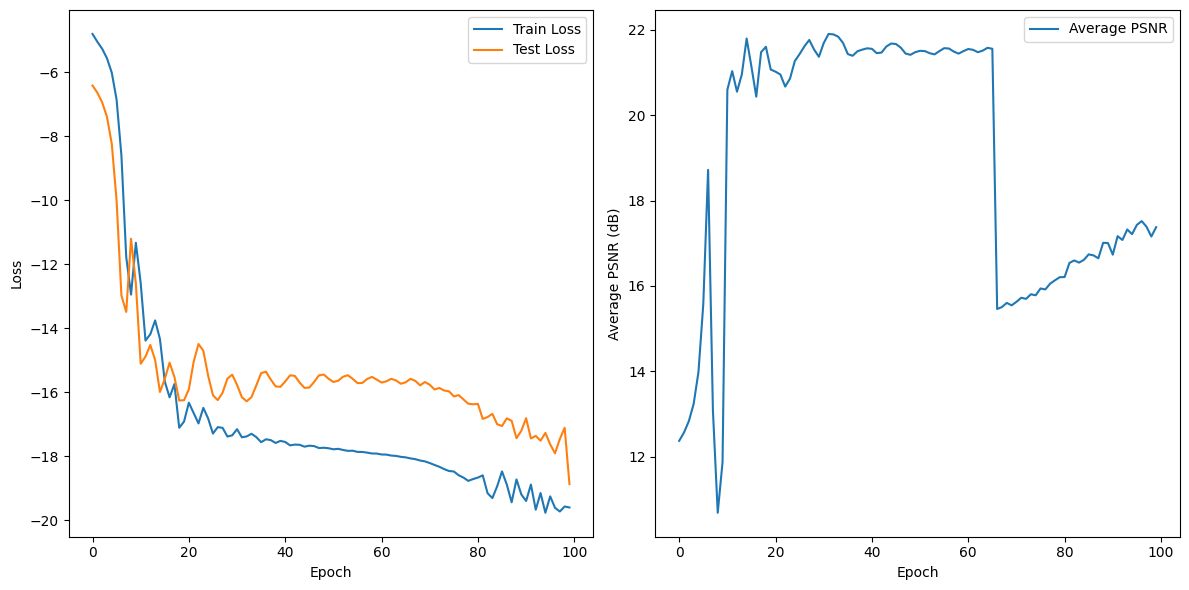

Training completed. Best PSNR: 21.90 dB
Training with parameters: {'batch_size': 128, 'dropout_rate': 0.0, 'learning_rate': 0.001, 'num_epochs': 100, 'weight_decay': 0.0001}
Epoch [1/100], Train Loss: -4.8821, Test Loss: -6.6918, Average PSNR: 12.59 dB
PSNR improved from -inf dB to 12.59 dB. Saving model
Epoch [2/100], Train Loss: -5.2828, Test Loss: -6.8955, Average PSNR: 12.76 dB
PSNR improved from 12.59 dB to 12.76 dB. Saving model
Epoch [3/100], Train Loss: -5.4776, Test Loss: -7.2102, Average PSNR: 13.03 dB
PSNR improved from 12.76 dB to 13.03 dB. Saving model
Epoch [4/100], Train Loss: -5.7763, Test Loss: -7.6686, Average PSNR: 13.42 dB
PSNR improved from 13.03 dB to 13.42 dB. Saving model
Epoch [5/100], Train Loss: -6.1984, Test Loss: -8.4303, Average PSNR: 14.06 dB
PSNR improved from 13.42 dB to 14.06 dB. Saving model
Epoch [6/100], Train Loss: -6.8952, Test Loss: -9.8401, Average PSNR: 15.27 dB
PSNR improved from 14.06 dB to 15.27 dB. Saving model
Epoch [7/100], Train Loss: -8

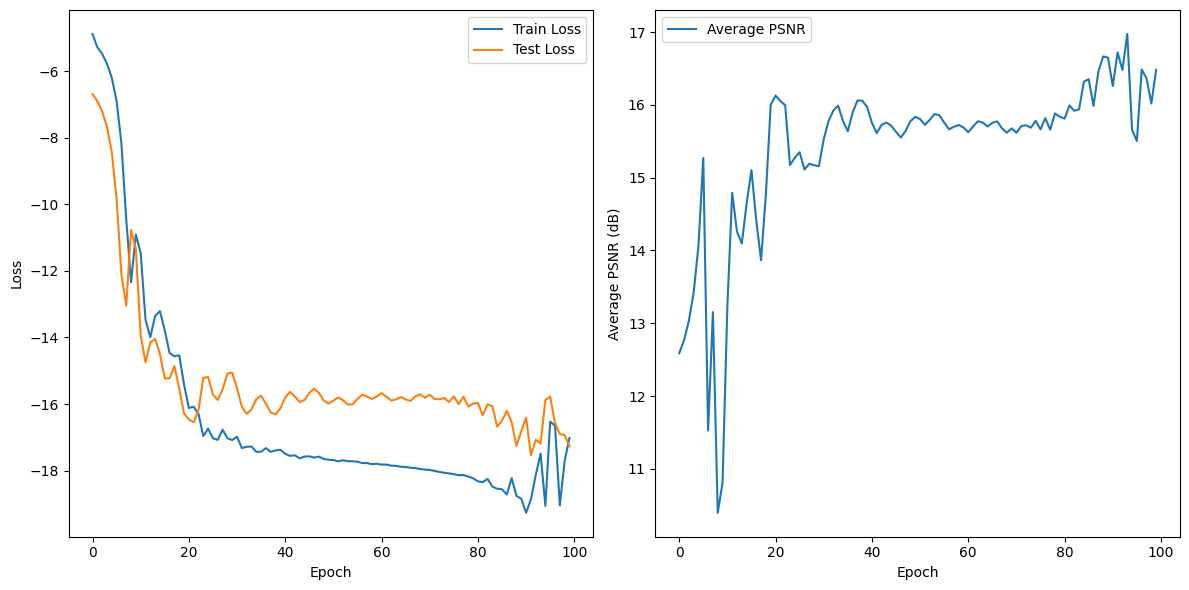

Training completed. Best PSNR: 16.98 dB
Training with parameters: {'batch_size': 128, 'dropout_rate': 0.0, 'learning_rate': 0.001, 'num_epochs': 100, 'weight_decay': 0.0005}
Epoch [1/100], Train Loss: -1.8804, Test Loss: -6.4424, Average PSNR: 12.35 dB
PSNR improved from -inf dB to 12.35 dB. Saving model
Epoch [2/100], Train Loss: -5.0074, Test Loss: -6.6583, Average PSNR: 12.54 dB
PSNR improved from 12.35 dB to 12.54 dB. Saving model
Epoch [3/100], Train Loss: -5.2166, Test Loss: -6.9364, Average PSNR: 12.78 dB
PSNR improved from 12.54 dB to 12.78 dB. Saving model
Epoch [4/100], Train Loss: -5.4865, Test Loss: -7.2820, Average PSNR: 13.08 dB
PSNR improved from 12.78 dB to 13.08 dB. Saving model
Epoch [5/100], Train Loss: -5.8130, Test Loss: -7.7664, Average PSNR: 13.49 dB
PSNR improved from 13.08 dB to 13.49 dB. Saving model
Epoch [6/100], Train Loss: -6.2575, Test Loss: -8.5841, Average PSNR: 14.19 dB
PSNR improved from 13.49 dB to 14.19 dB. Saving model
Epoch [7/100], Train Loss: -6

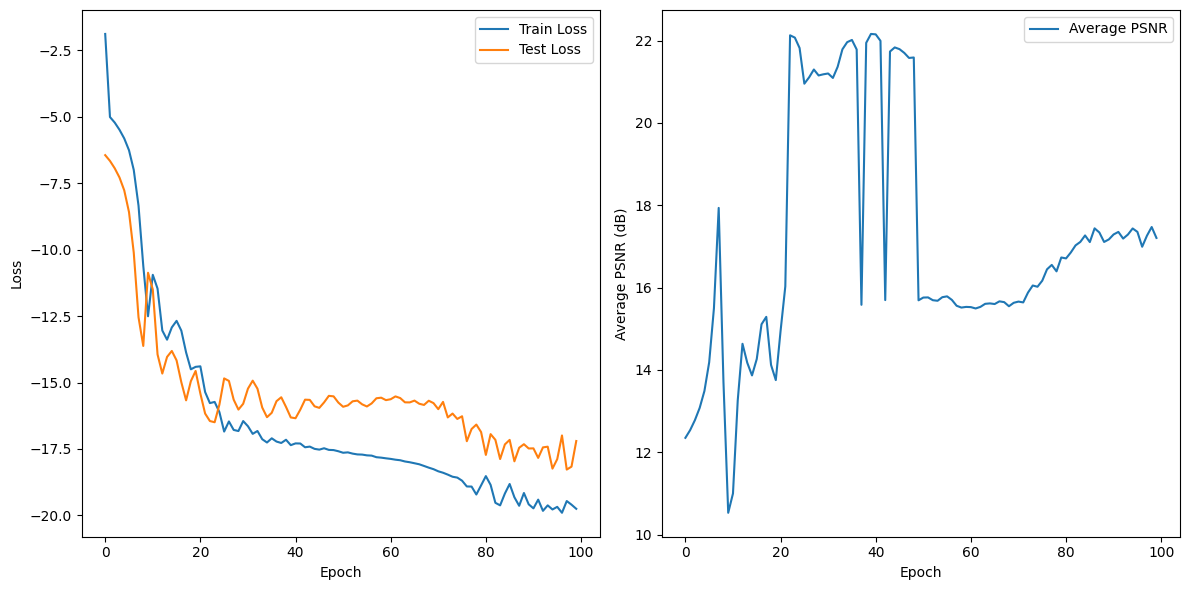

Training completed. Best PSNR: 22.16 dB
Training with parameters: {'batch_size': 128, 'dropout_rate': 0.0, 'learning_rate': 0.001, 'num_epochs': 150, 'weight_decay': 0.1}
Epoch [1/150], Train Loss: -3.6147, Test Loss: -6.2360, Average PSNR: 12.21 dB
PSNR improved from -inf dB to 12.21 dB. Saving model
Epoch [2/150], Train Loss: -4.8641, Test Loss: -6.4888, Average PSNR: 12.43 dB
PSNR improved from 12.21 dB to 12.43 dB. Saving model
Epoch [3/150], Train Loss: -5.1149, Test Loss: -6.8592, Average PSNR: 12.76 dB
PSNR improved from 12.43 dB to 12.76 dB. Saving model
Epoch [4/150], Train Loss: -5.4801, Test Loss: -7.4285, Average PSNR: 13.25 dB
PSNR improved from 12.76 dB to 13.25 dB. Saving model
Epoch [5/150], Train Loss: -6.0359, Test Loss: -8.3802, Average PSNR: 14.08 dB
PSNR improved from 13.25 dB to 14.08 dB. Saving model
Epoch [6/150], Train Loss: -6.9531, Test Loss: -10.1562, Average PSNR: 15.66 dB
PSNR improved from 14.08 dB to 15.66 dB. Saving model
Epoch [7/150], Train Loss: -8.6

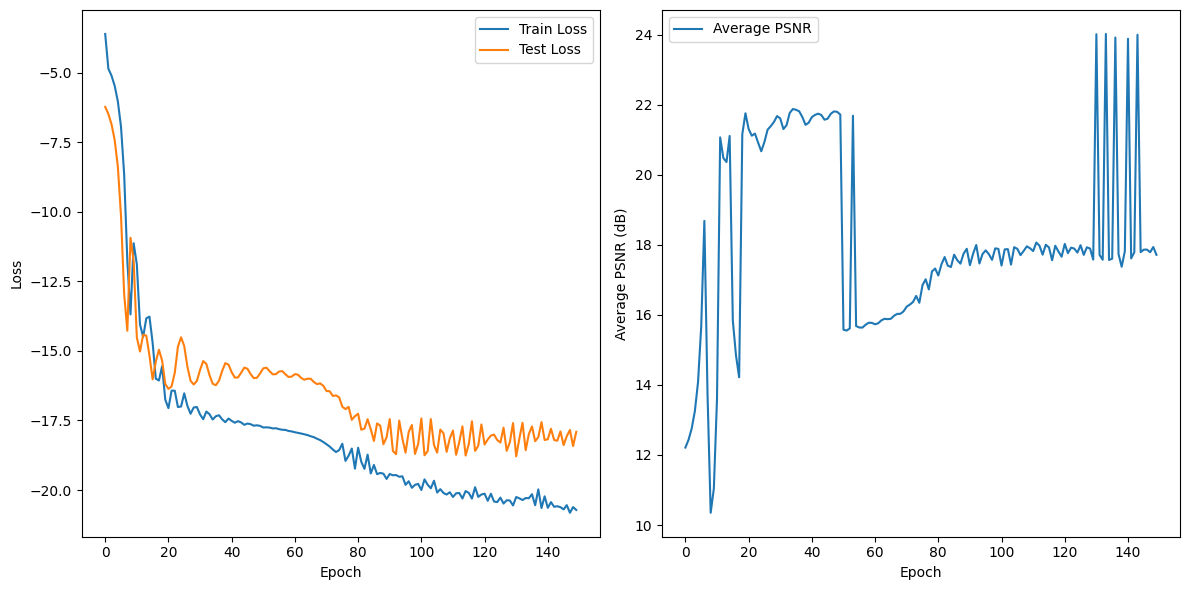

Training completed. Best PSNR: 24.02 dB
Best PSNR above threshold: 24.02 dB. Model saved as 'Low_Light_Image.pth'
24.017205126403386


In [9]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    total_loss = 0.0
    total_psnr = 0.0
    outputs_list = []
    targets_list = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss1 = criterion1(outputs, targets)
            loss2 = criterion2(outputs, targets)
            loss = loss1 + loss2
            total_loss += loss.item()

            psnr_value = psnr(outputs.detach().cpu().numpy(), targets.detach().cpu().numpy())
            total_psnr += psnr_value

            outputs_list.append(outputs.cpu().numpy())
            targets_list.append(targets.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    avg_psnr = total_psnr / len(test_loader)

    return avg_loss, avg_psnr, outputs_list, targets_list
global_best_psnr = -float('inf')
global_best_model_state = None

def hyperparameter_tuning(train_dataset, test_dataset, param_grid, best_psnr_threshold=23.0):
    global global_best_psnr, global_best_model_state
    best_params = None

    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")

        model = LowLightEnhanceNet().to(device)
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

        best_psnr, model_state = train_model(model, train_loader, optimizer, test_loader, num_epochs=params['num_epochs'])

        if best_psnr > global_best_psnr and best_psnr > best_psnr_threshold:
            global_best_psnr = best_psnr
            global_best_model_state = model_state
            best_params = params
            torch.save(global_best_model_state, "Low_Light_Image.pth")
            print(f"Best PSNR above threshold: {global_best_psnr:.2f} dB. Model saved as 'Low_Light_Image.pth'")
            return global_best_model_state, best_params

            
    print(f"Best parameters: {best_params}")
    print(f"Best PSNR: {global_best_psnr:.2f} dB")

    return global_best_model_state, best_params



best_model, best_params = hyperparameter_tuning(train_dataset, test_dataset, param_grid)

print(global_best_psnr)

In [10]:
best_model = LowLightEnhanceNet().to(device)
best_model.load_state_dict(torch.load("Low_Light_Image.pth", map_location=device))
best_model.eval()

_, _, outputs_list, targets_list = evaluate_model(best_model, DataLoader(test_dataset, batch_size=1, shuffle=False), device)



In [11]:
print(best_params)

{'batch_size': 128, 'dropout_rate': 0.0, 'learning_rate': 0.001, 'num_epochs': 150, 'weight_decay': 0.1}


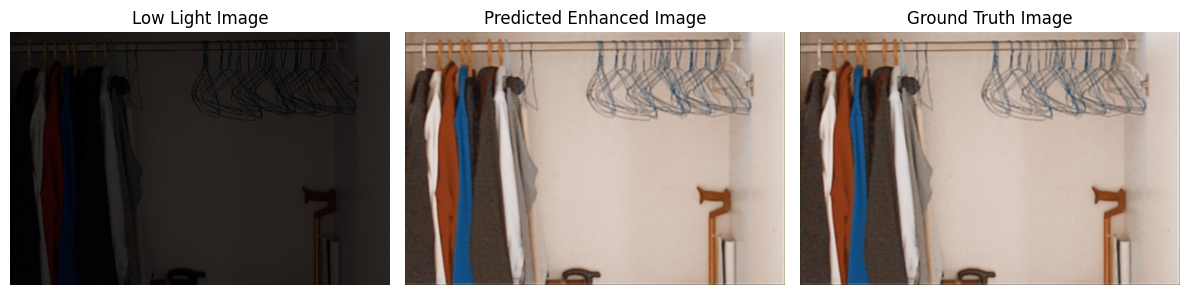

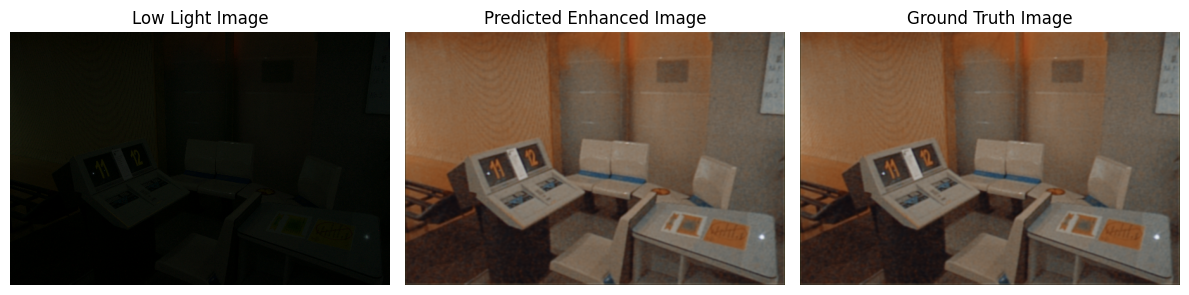

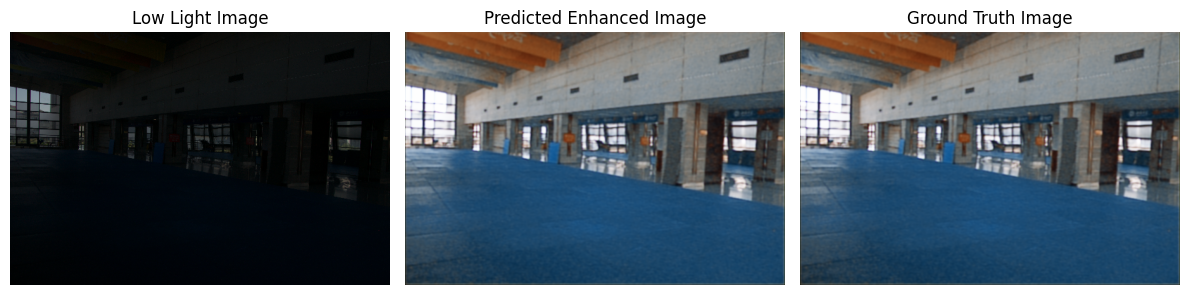

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(3):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Low Light Image")
    low_light_image = test_dataset[i][0].unsqueeze(0).to(device)  
    low_light_image_pil = transforms.ToPILImage()(low_light_image.cpu().squeeze(0))
    plt.imshow(low_light_image_pil)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Enhanced Image")
    predicted_image = outputs_list[i].squeeze(0).transpose(1, 2, 0)  
    predicted_image_tensor = torch.from_numpy(predicted_image).to(device)
    
    if predicted_image_tensor.dim() == 3:
        predicted_image_tensor = predicted_image_tensor.permute(2, 0, 1) 
    elif predicted_image_tensor.dim() == 2:
        predicted_image_tensor = predicted_image_tensor.unsqueeze(0)  
    
    predicted_image_pil = transforms.ToPILImage()(predicted_image_tensor.cpu().squeeze(0))
    plt.imshow(predicted_image_pil)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Ground Truth Image")
    ground_truth_image = targets_list[i].squeeze(0).transpose(1, 2, 0)
    ground_truth_image_tensor = torch.from_numpy(ground_truth_image).to(device)
    if ground_truth_image_tensor.dim() == 3:
        ground_truth_image_tensor = ground_truth_image_tensor.permute(2, 0, 1)  
    elif predicted_image_tensor.dim() == 2:
        ground_truth_image_tensor = ground_truth_image_tensor.unsqueeze(0)  
    
    ground_truth_image_pil = transforms.ToPILImage()(ground_truth_image_tensor.cpu().squeeze(0))
    plt.imshow(predicted_image_pil)
    plt.axis('off')

    plt.tight_layout()
    plt.show()
